# U Net Implementation in pytorch, inital similar to the paper
Sai Chamarty

In [78]:
# import stuff

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import InterpolationMode
from torchvision.transforms import functional as TF
import torch.nn.functional as F
import cv2
import sys
import os
import numpy as np
from PIL import Image
import glob

In [79]:
# we are working on the second segmentation task the U-net architecture tested on.

# TODO: add cuda items so we can use the compute available to us for more rapid training.

In [99]:
NUM_WORKERS = 4
BATCH_SIZE = 1  # batch size detailed in the paper
FLIP_PROBABILITY = 0.5
MOMENTUM_TERM = 0.99  # detailed in paper
NUM_OUTPUT_CHANNELS = 2  # detailed in paper

# Pixel-wise loss weight implemented in weighted_cross_entropy_loss function
# Weight initialization implemented in Net class
# Data augmentation: elastic deformations can be added later
"""We generate smooth
deformations using random displacement vectors on a coarse 3 by 3 grid. The
displacements are sampled from a Gaussian distribution with 10 pixels standard
deviation. Per-pixel displacements are then computed using bicubic interpolation."""


# online, recommended to train U-net using random crops of 256x256 for better generalization
# at inference time can still use arbitrary image size as long as divisble by 16.
def unet_transforms(image, mask, crop_size=512):
    # 1. Convert to tensors FIRST
    mask = (mask > 0).astype(np.uint8)
    mask = torch.tensor(mask, dtype=torch.long)

    image = TF.to_tensor(image)
    image = TF.normalize(image, mean=[0.5], std=[0.5])

    # 2. Random crop from original resolution (no resizing)
    i, j, h, w = torchvision.transforms.RandomCrop.get_params(
        image, output_size=(crop_size, crop_size)
    )
    image = TF.crop(image, i, j, h, w)
    mask = TF.crop(mask, i, j, h, w)

    # 3. Random flips
    if torch.rand(1) > 0.5:
        image = TF.hflip(image)
        mask = TF.hflip(mask)

    if torch.rand(1) > 0.5:
        image = TF.vflip(image)
        mask = TF.vflip(mask)

    return image, mask



In [100]:
class SegmentationDataset(Dataset):
    """
    Dataset for PhC-C2DH-U373:
    
    Images: PhC-C2DH-U373/01/t###.tif
    Masks:  PhC-C2DH-U373/01_ERR_SEG/mask###.tif
    """

    def __init__(self, image_dir, mask_paths, transforms=None):
        self.image_dir = image_dir        # path to "01"
        self.mask_paths = mask_paths      # list of mask files
        self.transforms = transforms

    def __len__(self):
        return len(self.mask_paths)

    def __getitem__(self, idx):
        # 1. Load mask
        mask_path = self.mask_paths[idx]
        mask = np.array(Image.open(mask_path))

        # 2. Extract frame number: mask034.tif → "034"
        base = os.path.basename(mask_path)            # "mask034.tif"
        frame = base.replace("mask", "").replace(".tif", "")  # "034"

        # 3. Build image path: t034.tif
        image_path = os.path.join(self.image_dir, f"t{frame}.tif")
        image = np.array(Image.open(image_path))

        # 4. Apply transforms
        if self.transforms:
            image, mask = self.transforms(image, mask)

        return image, mask


In [101]:
IMAGE_ROOT = "PhC-C2DH-U373"
IMAGE_DIR  = os.path.join(IMAGE_ROOT, "01")          # ONLY sequence 01 exists
MASK_DIR   = os.path.join(IMAGE_ROOT, "01_ERR_SEG")  # masks folder

# collect all mask files
mask_paths = sorted(glob.glob(os.path.join(MASK_DIR, "mask*.tif")))
print("Number of masks:", len(mask_paths))

train_dataset = SegmentationDataset(
    image_dir=IMAGE_DIR,
    mask_paths=mask_paths,
    transforms=unet_transforms,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)

print("Dataset size:", len(train_dataset))


Number of masks: 115
Dataset size: 115


In [102]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # U-Net architecture: padding=1 to maintain spatial dimensions after 3x3 conv
        # Downsampling path (encoder)
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1
        )
        self.conv2 = nn.Conv2d(
            in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1
        )
        self.conv3 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1
        )
        self.conv4 = nn.Conv2d(
            in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1
        )
        self.conv5 = nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1
        )
        self.conv6 = nn.Conv2d(
            in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1
        )
        self.conv7 = nn.Conv2d(
            in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1
        )
        self.conv8 = nn.Conv2d(
            in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1
        )
        self.conv9 = nn.Conv2d(
            in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1
        )
        self.conv10 = nn.Conv2d(
            in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1
        )

        # Max pooling for downsampling (2x2 with stride 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Upsampling path (decoder) - using transpose convolutions
        self.up1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512, stride=2, kernel_size=2
        )
        self.conv11 = nn.Conv2d(
            in_channels=1024, out_channels=512, stride=1, kernel_size=3, padding=1
        )
        self.conv12 = nn.Conv2d(
            in_channels=512, out_channels=512, stride=1, kernel_size=3, padding=1
        )

        self.up2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256, stride=2, kernel_size=2
        )
        self.conv13 = nn.Conv2d(
            in_channels=512, out_channels=256, stride=1, kernel_size=3, padding=1
        )
        self.conv14 = nn.Conv2d(
            in_channels=256, out_channels=256, stride=1, kernel_size=3, padding=1
        )

        self.up3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128, stride=2, kernel_size=2
        )
        self.conv15 = nn.Conv2d(
            in_channels=256, out_channels=128, stride=1, kernel_size=3, padding=1
        )
        self.conv16 = nn.Conv2d(
            in_channels=128, out_channels=128, stride=1, kernel_size=3, padding=1
        )

        self.up4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64, stride=2, kernel_size=2
        )
        self.conv17 = nn.Conv2d(
            in_channels=128, out_channels=64, stride=1, kernel_size=3, padding=1
        )
        self.conv18 = nn.Conv2d(
            in_channels=64, out_channels=64, stride=1, kernel_size=3, padding=1
        )

        # Output layer: 1x1 convolution to produce final segmentation map
        self.out1 = nn.Conv2d(
            in_channels=64,
            out_channels=NUM_OUTPUT_CHANNELS,
            stride=1,
            kernel_size=1,
            padding=0,
        )
        
        # Initialize weights as per paper (He initialization)
        self._initialize_weights()





    def _initialize_weights(self):
        """Initialize weights using He initialization as per paper"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)




    def forward(self, x):
        # Downsampling path (encoder)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        skip1 = x
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        skip2 = x
        x = self.pool(x)
        
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        skip3 = x
        x = self.pool(x)
        
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        skip4 = x
        x = self.pool(x)
        
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        # end of down sampling

        # Upsampling path (decoder) with skip connections
        # Up sampling 1
        x = self.up1(x)
        _, _, H, W = x.shape
        skip4_cropped = torchvision.transforms.CenterCrop([H, W])(skip4)
        x = torch.cat([x, skip4_cropped], dim=1)
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))

        # Up sampling 2
        x = self.up2(x)
        _, _, H, W = x.shape
        skip3_cropped = torchvision.transforms.CenterCrop([H, W])(skip3)
        x = torch.cat([x, skip3_cropped], dim=1)
        x = F.relu(self.conv13(x))
        x = F.relu(self.conv14(x))

        # Up sampling 3
        x = self.up3(x)
        _, _, H, W = x.shape
        skip2_cropped = torchvision.transforms.CenterCrop([H, W])(skip2)
        x = torch.cat([x, skip2_cropped], dim=1)
        x = F.relu(self.conv15(x))
        x = F.relu(self.conv16(x))

        # Up sampling 4
        x = self.up4(x)
        _, _, H, W = x.shape
        skip1_cropped = torchvision.transforms.CenterCrop([H, W])(skip1)
        x = torch.cat([x, skip1_cropped], dim=1)
        x = F.relu(self.conv17(x))
        x = F.relu(self.conv18(x))

        # Output layer
        x = self.out1(x)
        return x  # logits

In [103]:
# Te4st if one batch loads correctly

sample_img, sample_mask = train_dataset[0]

print("Image shape:", sample_img.shape)
print("Mask shape:", sample_mask.shape)
print("Unique mask values:", torch.unique(sample_mask))

Image shape: torch.Size([1, 512, 512])
Mask shape: torch.Size([512, 512])
Unique mask values: tensor([0, 1])


In [104]:
# initialize network and move it to GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

net = Net().to(device)


Using device: cuda


In [105]:
# Define loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.99)


### In order to compare this implementation of u-net vs the paper's results, we need the same metric - which would be the dice score.

In [106]:
def dice_score(pred, target, epsilon=1e-6):
    pred = pred.argmax(dim=1)  # get predicted class
    pred = pred.float()
    target = target.float()
    
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()

    dice = (2. * intersection + epsilon) / (union + epsilon)
    return dice.item()


In [107]:
# write the training loop:

def train_unet(net, train_loader, epochs=50):
    net.train()

    for epoch in range(epochs):
        total_loss = 0
        total_dice = 0

        for img, mask in train_loader:
            img = img.to(device)
            mask = mask.to(device)

            optimizer.zero_grad()
            output = net(img)

            loss = criterion(output, mask)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_dice += dice_score(output, mask)

        print(f"Epoch {epoch+1}: Loss={total_loss/len(train_loader):.4f} | Dice={total_dice/len(train_loader):.4f}")


In [108]:
# train the unet now, initially for 50 epochs, then later 300 epochs:
train_unet(net, train_loader, epochs=50)

Epoch 1: Loss=0.3059 | Dice=0.0909
Epoch 2: Loss=0.2399 | Dice=0.3092
Epoch 3: Loss=0.1520 | Dice=0.5420
Epoch 4: Loss=0.1068 | Dice=0.7098
Epoch 5: Loss=0.0886 | Dice=0.7850
Epoch 6: Loss=0.0666 | Dice=0.8501
Epoch 7: Loss=0.0536 | Dice=0.8812
Epoch 8: Loss=0.0373 | Dice=0.9136
Epoch 9: Loss=0.0312 | Dice=0.9273
Epoch 10: Loss=0.0260 | Dice=0.9404
Epoch 11: Loss=0.0222 | Dice=0.9484
Epoch 12: Loss=0.0209 | Dice=0.9521
Epoch 13: Loss=0.0182 | Dice=0.9590
Epoch 14: Loss=0.0169 | Dice=0.9620
Epoch 15: Loss=0.0153 | Dice=0.9653
Epoch 16: Loss=0.0153 | Dice=0.9652
Epoch 17: Loss=0.0208 | Dice=0.9569
Epoch 18: Loss=0.0237 | Dice=0.9504
Epoch 19: Loss=0.0193 | Dice=0.9587
Epoch 20: Loss=0.0149 | Dice=0.9661
Epoch 21: Loss=0.0123 | Dice=0.9722
Epoch 22: Loss=0.0109 | Dice=0.9761
Epoch 23: Loss=0.0111 | Dice=0.9747
Epoch 24: Loss=0.0111 | Dice=0.9748
Epoch 25: Loss=0.0100 | Dice=0.9776
Epoch 26: Loss=0.0099 | Dice=0.9781
Epoch 27: Loss=0.0091 | Dice=0.9787
Epoch 28: Loss=0.0092 | Dice=0.9796
E

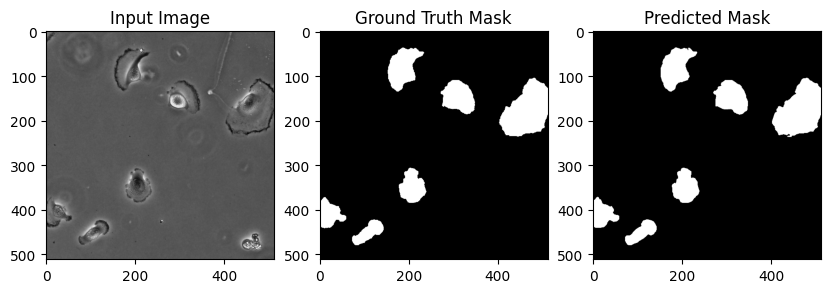

In [109]:
# visualize prediction vs ground truth

import matplotlib.pyplot as plt

net.eval()
with torch.no_grad():
    img, mask = train_dataset[0]
    img_gpu = img.unsqueeze(0).to(device)
    pred = net(img_gpu)
    pred_mask = pred.argmax(dim=1).squeeze().cpu()

plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(img.permute(1,2,0).cpu(), cmap='gray')

plt.subplot(1,3,2)
plt.title("Ground Truth Mask")
plt.imshow(mask.cpu(), cmap='gray')

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(pred_mask, cmap='gray')

plt.show()


### so what did I update in here?
- I used original resolution of 512x512, instead of 256x256 used previously.
- Go around 50 epochs for training, and got a dice score of 0.98. That is a good score as you can see the images above.
